In [15]:
import json

# Path to the dataset
# train_file_path = "/content/drive/MyDrive/your_path/train.json"
train_file_path = "train.json"

def flatten_evidence(evidence):
    flattened = []
    for item in evidence:
        try:
            while isinstance(item[0], list):
                item = item[0]
            for evidence_item in item:
                flattened.append(evidence_item)
        except:
            continue
    return flattened

# Load and parse the dataset
def load_strategyqa_train_data(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)  # Load JSON file

    train_data = []

    for item in data:
        parsed_entry = {
            "id": item.get("qid", ""),
            "term": item.get("term", ""),         # Extract term
            "description": item.get("description", ""),  # Extract description
            "question": item["question"],         # Extract question
            "answer": item["answer"],             # Extract answer (True/False)
            "facts": item.get("facts", []),         # Extract facts
            "decomposition": item.get("decomposition", []),  # Extract decomposition
            "evidence": flatten_evidence(item.get("evidence", []))  # Extract evidence
        }
        train_data.append(parsed_entry)

    return train_data

# Load the training data
train_data = load_strategyqa_train_data(train_file_path)

# Print a sample entry for verification
print(json.dumps(train_data[:2], indent=4))
print(len(train_data))


[
    {
        "id": "2bc9c4f9c19c167187f2",
        "term": "Genghis Khan",
        "description": "founder and first Great Khan of the Mongol Empire",
        "question": "Are more people today related to Genghis Khan than Julius Caesar?",
        "answer": true,
        "facts": [
            "Julius Caesar had three children.",
            "Genghis Khan had sixteen children.",
            "Modern geneticists have determined that  out of every 200 men today has DNA that can be traced to Genghis Khan."
        ],
        "decomposition": [
            "How many kids did Julius Caesar have?",
            "How many kids did Genghis Khan have?",
            "Is #2 greater than #1?"
        ],
        "evidence": [
            "Caesarion-2",
            "Julia (daughter of Caesar)-1",
            "Julius Caesar-75",
            "Gaius Julius Caesar-7"
        ]
    },
    {
        "id": "03caf265939fab701dee",
        "term": "The Police",
        "description": "English rock band",
  

In [16]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

# Use GPT-Neo 125M public model
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M", add_prefix_space=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

class QuestionDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

        # Add a special token to separate decomposition and evidence
        self.sep_token = "[SEP]"
        if self.sep_token not in self.tokenizer.get_vocab():
            self.tokenizer.add_tokens([self.sep_token])
            self.tokenizer.model_max_length = self.max_len
            self.tokenizer.init_kwargs['model_max_length'] = self.max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        id = item['id']
        question = item["question"]
        term = item["term"]
        description = item["description"]
        facts = " ".join(item["facts"])
        decomposition = item["decomposition"]
        evidence = item["evidence"]

        # Combine inputs (question, term, description, facts)
        combined_input = f"{question} {term} {description} {facts}"

        # Tokenize the input
        encoding = self.tokenizer(
            combined_input,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        # Binary answer label
        answer_label = 1 if item["answer"] else 0
        answer_label = torch.tensor(answer_label, dtype=torch.float)

        # Prepare labels by concatenating decomposition and evidence
        label = ""
        for d in decomposition:
            label += d + " "
        label += self.sep_token
        for e in evidence:
            label += "|" + e

        # Tokenize the label (no is_split_into_words flag now)
        combined_labels = self.tokenizer(
            label,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )["input_ids"].squeeze(0)

        # Validate label values against vocabulary size
        vocab_size = len(self.tokenizer)
        if (combined_labels >= vocab_size).any():
            raise ValueError(f"Invalid label value found. Label values must be less than {vocab_size}.")

        return {
            "id": id,
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "answer_label": answer_label,
            "labels": combined_labels  # Combined decomposition and evidence
        }

# Create the training dataset and loader
train_dataset = QuestionDataset(train_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


In [17]:
# Print decoded labels to verify the output
print(tokenizer.decode(next(iter(train_loader))["labels"][0], skip_special_tokens=True))
print(next(iter(train_loader))["labels"][0].shape)

# For validation, load the dev set (update path if needed)
val_data = 'dev.json'
val_data = load_strategyqa_train_data(val_data)
val_dataset = QuestionDataset(val_data, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
print(len(val_dataset))


 What is the native range of wolverines? What state is Miami located in? Is #2 included in #1? [SEP] |Wolverine-16|Wolverine-2|Wolverine-2
torch.Size([512])
229


In [18]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer

class GPTNeoMultiTaskWrapper(nn.Module):
    def __init__(self, model_name="EleutherAI/gpt-neo-125M", max_len=512):
        super(GPTNeoMultiTaskWrapper, self).__init__()
        self.gptneo = AutoModelForCausalLM.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
        self.max_len = max_len

        # Add special token if not present
        self.sep_token = "[SEP]"
        if self.sep_token not in self.tokenizer.get_vocab():
            self.tokenizer.add_tokens([self.sep_token])
            self.gptneo.resize_token_embeddings(len(self.tokenizer))

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        # Additional layers for classification task
        self.fc1 = nn.Linear(self.gptneo.config.vocab_size, self.max_len)
        self.fc2 = nn.Linear(self.max_len, 128)
        self.fc3 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward_generate(self, input_ids, attention_mask):
        outputs = self.gptneo(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits

    def forward_classify(self, input_ids, attention_mask):
        generate_outputs = self.forward_generate(input_ids, attention_mask)
        fc1_output = self.relu(self.fc1(generate_outputs))
        fc2_output = self.relu(self.fc2(fc1_output))
        fc3_output = self.sigmoid(self.fc3(fc2_output))
        final_output = fc3_output.mean(dim=1)
        return generate_outputs, final_output

    def generate(self, input_ids, attention_mask, max_new_tokens=128):
        generated_ids = self.gptneo.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            num_return_sequences=1
        )
        return self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)


In [19]:
from sklearn.metrics import accuracy_score

def train_generation(model, dataloader, optimizer, device, epochs=3):
    """
    Train the model on the generation task.
    """
    # Ensure language model parameters are trainable
    for param in model.gptneo.parameters():
        param.requires_grad = True

    # Freeze classification layers during generation training
    for param in model.fc1.parameters():
        param.requires_grad = False
    for param in model.fc2.parameters():
        param.requires_grad = False
    for param in model.fc3.parameters():
        param.requires_grad = False

    model.train()
    train_losses = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            generate_outputs = model.forward_generate(input_ids, attention_mask)

            loss = nn.CrossEntropyLoss()(
                generate_outputs.view(-1, generate_outputs.size(-1)),
                labels.view(-1)
            )

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(dataloader)
        train_losses.append(avg_epoch_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss}")

    return train_losses

def train_classification(model, train_dataloader, val_dataloader, optimizer, device, epochs=3):
    """
    Train the model on the classification task.
    """
    # Freeze language model parameters
    for param in model.gptneo.parameters():
        param.requires_grad = False

    # Ensure classification layers are trainable
    for param in model.fc1.parameters():
        param.requires_grad = True
    for param in model.fc2.parameters():
        param.requires_grad = True
    for param in model.fc3.parameters():
        param.requires_grad = True

    model.train()
    train_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        all_preds = []
        all_labels = []

        for batch in train_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            answer_labels = batch["answer_label"].to(device)

            optimizer.zero_grad()
            _, classify_outputs = model.forward_classify(input_ids, attention_mask)

            loss = nn.BCELoss()(classify_outputs.squeeze(), answer_labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            preds = (classify_outputs.squeeze() > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(answer_labels.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        train_accs.append(train_acc)
        avg_epoch_loss = epoch_loss / len(train_dataloader)
        train_losses.append(avg_epoch_loss)
        val_acc = evaluate(model, val_dataloader, device)
        val_accs.append(val_acc)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss}, Train Acc: {train_acc}, Val Acc: {val_acc}")

    return train_losses, train_accs, val_accs

def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            answer_labels = batch["answer_label"].to(device)
            _, classify_outputs = model.forward_classify(input_ids, attention_mask)
            preds = (classify_outputs.squeeze() > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(answer_labels.cpu().numpy())
    return accuracy_score(all_labels, all_preds)


In [20]:
from torch.optim import AdamW
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = GPTNeoMultiTaskWrapper(model_name="EleutherAI/gpt-neo-125M")
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)


cuda


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

2025-03-18 04:37:10.355575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-18 04:37:10.355627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-18 04:37:10.356779: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 04:37:10.365290: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Epoch 1/15, Loss: 0.9401381159013555
Epoch 2/15, Loss: 0.6773982329886089
Epoch 3/15, Loss: 0.6146886394929516
Epoch 4/15, Loss: 0.580781712088474
Epoch 5/15, Loss: 0.5517451201760492
Epoch 6/15, Loss: 0.5246807491594507
Epoch 7/15, Loss: 0.502447530280712
Epoch 8/15, Loss: 0.4817375805257827
Epoch 9/15, Loss: 0.4633293616217236
Epoch 10/15, Loss: 0.4459662184465763
Epoch 11/15, Loss: 0.4301436952380247
Epoch 12/15, Loss: 0.4157841571772745
Epoch 13/15, Loss: 0.40065551243087116
Epoch 14/15, Loss: 0.389675746014876
Epoch 15/15, Loss: 0.3773938512155252


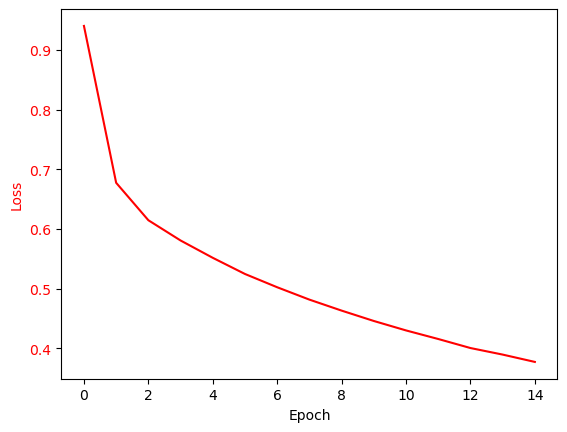

Epoch 1/5, Loss: 53.1440870355266, Train Acc: 0.4657933042212518, Val Acc: 0.4672489082969432
Epoch 2/5, Loss: 53.29457364341085, Train Acc: 0.46773410965550705, Val Acc: 0.4672489082969432
Epoch 3/5, Loss: 53.207364341085274, Train Acc: 0.46773410965550705, Val Acc: 0.4672489082969432
Epoch 4/5, Loss: 53.17829457364341, Train Acc: 0.46773410965550705, Val Acc: 0.4672489082969432
Epoch 5/5, Loss: 53.29457364341085, Train Acc: 0.46773410965550705, Val Acc: 0.4672489082969432


In [21]:
import gc
import matplotlib.pyplot as plt
gc.collect()
torch.cuda.empty_cache()

# Train generation task
train_losses_generation = train_generation(model, train_loader, optimizer, device, epochs=15)

def plot_gen(losses):
    fig, ax1 = plt.subplots()
    color = 'red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(losses, color=color, label='Training Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    plt.show()

plot_gen(train_losses_generation)

# Train classification task
train_losses, train_accs, val_accs = train_classification(model, train_loader, val_loader, optimizer, device, epochs=5)


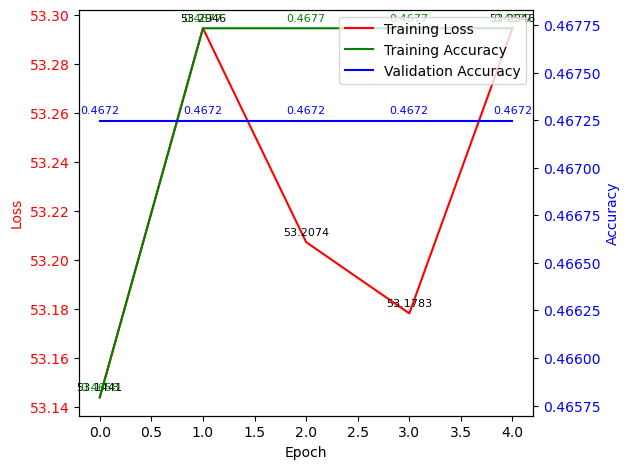

In [22]:
import matplotlib.pyplot as plt
def plot_results(losses, train_accs, val_accs):
    fig, ax1 = plt.subplots()
    color = 'red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(losses, color=color, label='Training Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    for i, loss in enumerate(losses):
        ax1.annotate(f'{loss:.4f}', (i, loss), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)
    ax2 = ax1.twinx()
    color = 'blue'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(train_accs, color='green', label='Training Accuracy')
    ax2.plot(val_accs, color='blue', label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    for i, train_acc, val_acc in zip(range(len(train_accs)), train_accs, val_accs):
        ax2.annotate(f'{train_acc:.4f}', (i, train_acc), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='green')
        ax2.annotate(f'{val_acc:.4f}', (i, val_acc), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='blue')
    fig.tight_layout()
    fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
    plt.show()

plot_results(train_losses, train_accs, val_accs)


In [ ]:
def plot_gen(losses):
  fig, ax1 = plt.subplots()

  # Plot Losses
  color = 'red'
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss', color=color)
  ax1.plot(losses, color=color, label='Training Loss')  # Add label for legend
  ax1.tick_params(axis='y', labelcolor=color)
  plt.show()
plot_gen(train_losses_generation)

In [23]:
a = next(iter(val_loader))
model.eval()
with torch.no_grad():
    input_ids = a["input_ids"].to(device)
    attention_mask = a["attention_mask"].to(device)
    labels = a["answer_label"].to(device)
    _, outputs = model.forward_classify(input_ids, attention_mask)
    print(outputs.shape)
    predicted = (outputs > 0.5).float()
    print(predicted, labels)


torch.Size([8, 1])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0') tensor([0., 1., 0., 1., 0., 0., 0., 1.], device='cuda:0')


In [24]:
gen = model.forward_generate(input_ids, attention_mask)
label = a['labels'].to(device)
loss = nn.CrossEntropyLoss()(gen.view(-1, gen.size(-1)), label.view(-1))
print(loss)
print(model.generate(input_ids, attention_mask, 10))


tensor(0.6718, device='cuda:0')


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


[' Will the Albany in Georgia reach a hundred thousand occupants before the one in New York? Albany, Georgia City in Georgia, United States Albany, GA has around 75,000 people Albany, NY has almost 100,000 people', ' Is the language used in Saint Vincent and the Grenadines rooted in English? Saint Vincent and the Grenadines Country in the Caribbean The primary language spoken in Saint Vincent and the Grenadines is Vincentian Creole. Vincentian Creole is English-based, with elements of French, Antillean Creole, and indigenous South American and African languages.', ' Is greed the most prevalent of the Seven Deadly Sins? Greed an inordinate or insatiable longing, especially for wealth, status, and power Greed is a longing for wealth and power. White collar crime involves businesses stealing money or assets from people.  5-10% of arrests per 100,000 arrests were for  white collar crime according to Department of Justice statistics. Gluttony is the overindulgence in food or similar things.

In [25]:
def compile_output(model, dataloader, tokenizer, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    predictions = {}
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            item_ids = batch['id']
            generated_text = model.generate(input_ids, attention_mask)
            for i, item_id in enumerate(item_ids):
                label_text = generated_text[i]
                if tokenizer.sep_token not in label_text:
                    print('SEP not in generated text')
                    continue
                decomposition_text, paragraph_text = label_text.split(tokenizer.sep_token)
                decomposition_text = decomposition_text.strip()
                paragraph_text = paragraph_text.replace(tokenizer.eos_token, "").strip().rstrip()
                decomposition_list = [q.strip() for q in decomposition_text.split("?") if q.strip()]
                decomposition_list = [q + "?" for q in decomposition_list]
                paragraph_list = [p.strip() for p in paragraph_text.split("|") if p.strip()]
                predictions[item_id] = {
                    "decomposition": decomposition_list,
                    "paragraphs": paragraph_list
                }
    return predictions


In [26]:
def compile_output(model, dataloader, tokenizer, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    predictions = {}
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            item_ids = batch['id']
            generated_text = model.generate(input_ids, attention_mask)
            for i, item_id in enumerate(item_ids):
                label_text = generated_text[i]
                if tokenizer.sep_token not in label_text:
                    print('SEP not in generated text')
                    continue
                decomposition_text, paragraph_text = label_text.split(tokenizer.sep_token)
                decomposition_text = decomposition_text.strip()
                paragraph_text = paragraph_text.replace(tokenizer.eos_token, "").strip().rstrip()
                decomposition_list = [q.strip() for q in decomposition_text.split("?") if q.strip()]
                decomposition_list = [q + "?" for q in decomposition_list]
                paragraph_list = [p.strip() for p in paragraph_text.split("|") if p.strip()]
                predictions[item_id] = {
                    "decomposition": decomposition_list,
                    "paragraphs": paragraph_list
                }
    return predictions


# Eval

In [27]:
d = val_data[:3]
dd = QuestionDataset(d, tokenizer)
dloader = DataLoader(dd, batch_size=8, shuffle=False)
for batch in dloader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    item_ids = batch['id']
    generated_text = model.generate(input_ids, attention_mask)
    for i, item_id in enumerate(item_ids):
        label_text = generated_text[i]
        print(label_text)
        decomposition_text, paragraph_text = label_text.split(tokenizer.sep_token)
        decomposition_text = decomposition_text.strip()
        paragraph_text = paragraph_text.replace(tokenizer.eos_token, "").strip().rstrip()
        decomposition_list = [q.strip() for q in decomposition_text.split("?") if q.strip()]
        decomposition_list = [q + "?" for q in decomposition_list]
        paragraph_list = [p.strip() for p in paragraph_text.split("|") if p.strip()]
        print(decomposition_list)
        print(paragraph_list)


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Will the Albany in Georgia reach a hundred thousand occupants before the one in New York? Albany, Georgia City in Georgia, United States Albany, GA has around 75,000 people Albany, NY has almost 100,000 people


ValueError: too many values to unpack (expected 2)